# Summary

GLM for decoding feedback and value, using single unit activity. In the manuscript: **Fig. 3D**.

This notebook requires to run `analysis/glm.py` first to generate the GLM analysis.

---
# Setup

In [1]:
# imports
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from popy.decoder_tools import mask_N_consecutives
import popy.config as cfg

# fontsize is 8
plt.rcParams.update({'font.size': 8})


In [2]:
# local functions
PALETTE = {
    'Fb only': '#1b9e77',
    'Value only': '#d95f02',
    'Both': '#7570b3',
    'None': 'lightgrey',
}


# helper functions
def load_res():
    floc = os.path.join(
        cfg.PROJECT_PATH_LOCAL,
        "data",
        "results",
        "glm",
        "scores.nc",
    )
    print(f"loading {floc}")

    ds = xr.open_dataset(floc, engine="netcdf4")
    ds.close()
    return ds.copy("deep")

def add_lpfc_subregions(ds_fb_value_full):
    # 
    subregions_encoding = {
        '210322': 'vLPFC',
        '020622': 'dLPFC',
        '210422': 'vLPFC',
        '240921': 'dLPFC'
    }

    sessions = ds_fb_value_full.session.values
    areas = ds_fb_value_full.area.values
    subregions = []
    for session, area in zip(sessions, areas):
        lpfc_subregion = subregions_encoding[session]
        if area == 'LPFC':
            subregions.append(lpfc_subregion)
        else:
            subregions.append(area)

    ds_fb_value_full = ds_fb_value_full.assign_coords(
        subregion = ('unit', subregions)
    )
    
    return ds_fb_value_full

def extract_significant_units(ds_fb_value_full, plim=0.05, n_consecutives=2, t_feedback=[0, 1], t_history=[-1, 0]):

    # get significant times and units
    signifs_fb_all = ds_fb_value_full.sel(time=slice(*t_feedback)).CPDs_p_vals_feedback < plim
    signifs_val_all = ds_fb_value_full.sel(time=slice(*t_history)).CPDs_p_vals_stay_value < plim

    signifs_fb = mask_N_consecutives(signifs_fb_all, N=n_consecutives, non_signif_coding='0')  # mask 3 consecutives
    signifs_val = mask_N_consecutives(signifs_val_all, N=n_consecutives, non_signif_coding='0')  # mask 3 consecutives

    # is there ANY time point for a given unit that is significant?
    if_signifs_fb = signifs_fb.sum("time") > 0
    if_signifs_val = signifs_val.sum("time") > 0

    signif_groups = []
    for if_signif_fb, if_signif_value in zip(if_signifs_fb.values, if_signifs_val.values):
        if (not if_signif_fb) and (not if_signif_value):
            signif_groups.append('None')
        elif if_signif_fb and if_signif_value:
            signif_groups.append('Both')
        elif if_signif_fb:
            signif_groups.append('Fb only')
        elif if_signif_value:
            signif_groups.append('Value only')

    # get corresponding tvals
    tvals_fb_all = ds_fb_value_full.sel(time=slice(*t_feedback)).t_vals_feedback
    #tvals_fb_all = tvals_fb_all.where(signifs_fb, np.nan)  # mask non-significant values
    tvals_fb_max = tvals_fb_all.max("time")
    tvals_fb_min = tvals_fb_all.min("time")

    tvals_fb_best = []
    for tval_fb_max, tval_fb_min in zip(tvals_fb_max.values, tvals_fb_min.values):
        if tval_fb_max >= np.abs(tval_fb_min):
            tvals_fb_best.append(tval_fb_max)
        else:
            tvals_fb_best.append(tval_fb_min)

    tvals_val_all = ds_fb_value_full.sel(time=slice(*t_history)).t_vals_stay_value
    #tvals_val_all = tvals_val_all.where(signifs_val, np.nan)
    tvals_val_max = tvals_val_all.max("time")
    tvals_val_min = tvals_val_all.min("time")

    tvals_val_best = []
    for tval_val_max, tval_val_min in zip(tvals_val_max.values, tvals_val_min.values):
        if tval_val_max >= np.abs(tval_val_min):
            tvals_val_best.append(tval_val_max)
        else:
            tvals_val_best.append(tval_val_min)

    df_unit_significances = pd.DataFrame(
        {
            "unit": ds_fb_value_full.unit.values,
            "monkey": ds_fb_value_full.monkey,
            "session": ds_fb_value_full.session,
            "area": ds_fb_value_full.area,
            "subregion": ds_fb_value_full.subregion,
            #"channel": ds_fb_value_full.channel,
            "signif_group": signif_groups,
            "t_vals_feedback": tvals_fb_best,
            "t_vals_value": tvals_val_best,
        }
    )

    # remove 1% outliers from t_vals_feedback and t_vals_stay_value
    '''outliers_fb = df_unit_significances.t_vals_feedback.abs() > df_unit_significances.t_vals_feedback.abs().quantile(0.99)
    outliers_value = df_unit_significances.t_vals_value.abs() > df_unit_significances.t_vals_value.abs().quantile(0.99)

    df_unit_significances = df_unit_significances[~(outliers_fb | outliers_value)]
    print(f"Number of units removed due to outliers: {(outliers_fb | outliers_value).sum()}")'''

    # monkey, session, area are strings
    df_unit_significances["session"] = df_unit_significances["session"].astype(str)
    df_unit_significances["area"] = df_unit_significances["area"].astype(str)
    df_unit_significances["monkey"] = df_unit_significances["monkey"].astype(str)

    # return
    return df_unit_significances

def plot_coeffs_vs_feedback_value(df_unit_significances, paper_format=False):
    from matplotlib.gridspec import GridSpec

    # Set font size globally
    plt.rcParams.update({'font.size': 8})

    # Calculate figure dimensions
    n_subplots = len(df_unit_significances.groupby("subregion"))
    
    if paper_format:
        subplot_size = 1.0  # inches per subplot (square)
        s = 3  # smaller points for compact subplots
    else:
        subplot_size = 4.0  # larger squares for non-paper
        s = 30

    # Calculate total figure size based on square subplots
    total_width = subplot_size * n_subplots * 1.5  # 1.5 factor for marginals
    height = subplot_size * 1.3  # 1.3 factor for marginals

    figsize = (total_width, height)


    # Create figure with custom gridspec for jointplot-like layout
    fig = plt.figure(figsize=figsize)

    # Calculate grid dimensions: each subplot needs 3x3 grid (main plot + marginals)
    grid_cols = n_subplots * 3
    gs = GridSpec(3, grid_cols, figure=fig, 
                height_ratios=[.5, 3, 0.2], width_ratios=[3, .5, 0.5] * n_subplots,
                hspace=0.05, wspace=0.25)

    for i, (area, sub_df) in enumerate(df_unit_significances.groupby("subregion")):
        # Calculate grid positions for this subplot
        col_start = i * 3
        
        # Main scatter plot
        ax_main = fig.add_subplot(gs[1, col_start])
        
        # Top marginal (x-axis histogram)
        ax_top = fig.add_subplot(gs[0, col_start], sharex=ax_main)
        
        # Right marginal (y-axis histogram)
        ax_right = fig.add_subplot(gs[1, col_start + 1], sharey=ax_main)
        
        # Create scatter plot for each significance group
        for group, group_df in sub_df.groupby("signif_group"):
            color = PALETTE[group]
            
            # Main scatter plot
            group_df_undersampled = group_df.sample(n=min(len(group_df), 10000), random_state=42)  # downsample to max 1000 points
            ax_main.scatter(group_df_undersampled["t_vals_feedback"], group_df_undersampled["t_vals_value"],
                        c=color, s=s, alpha=0.4, 
                        edgecolors='none', linewidth=0.3, label=group)
        
        # Top marginal histogram (x-values)
        '''tvals_fb = sub_df.loc[(sub_df["signif_group"] == "Both") | (sub_df["signif_group"] == "Fb only"), "t_vals_feedback"]
        ax_top.hist(tvals_fb, bins=10, alpha=0.5, color='grey', histtype='stepfilled')'''
        
        """# Statistical test for feedback
        pos_count = (tvals_fb > 0).sum()
        neg_count = (tvals_fb < 0).sum()
        total_count = pos_count + neg_count
        print(f"{area} - feedback: pos: {pos_count}, neg: {neg_count} -> proportion of negatives: {neg_count / total_count:.2f}")
        p_value_fb = binomtest(pos_count, total_count, p=0.5, alternative='two-sided')
        print(f"Binomial test for {area} - feedback: p-value = {p_value_fb.pvalue:.4f}")
        
        # Add significance stars for feedback
        if p_value_fb.pvalue < 0.001:
            sig_text = '***'
        elif p_value_fb.pvalue < 0.01:
            sig_text = '**'
        elif p_value_fb.pvalue < 0.05:
            sig_text = '*'
        else:
            sig_text = 'n.s.'
        
        ax_top.text(0.5, 1.2, sig_text, transform=ax_top.transAxes, 
                   ha='center', va='center', fontsize=8)
        ax_top.plot([.35, .65], [.98, .98], 'k-', linewidth=.5, transform=ax_top.transAxes)
        """
        # Right marginal histogram (y-values)
        '''tvals_value = sub_df.loc[(sub_df["signif_group"] == "Both") | (sub_df["signif_group"] == "Value only"), "t_vals_value"]
        ax_right.hist(tvals_value, bins=10, alpha=0.5, color='grey', histtype='stepfilled', orientation='horizontal')'''

        # Statistical test for value
        """pos_count = (tvals_value > 0).sum()
        neg_count = (tvals_value < 0).sum()
        total_count = pos_count + neg_count
        print(f"{area} - value: pos: {pos_count}, neg: {neg_count} -> proportion of negatives: {neg_count / total_count:.2f}")
        p_value_val = binomtest(pos_count, total_count, p=0.5, alternative='two-sided')
        print(f"Binomial test for {area} - value: p-value = {p_value_val.pvalue:.4f}")

        # Add significance stars for value
        if p_value_val.pvalue < 0.001:
            sig_text = '***'
        elif p_value_val.pvalue < 0.01:
            sig_text = '**'
        elif p_value_val.pvalue < 0.05:
            sig_text = '*'
        else:
            sig_text = 'n.s.'
        
        # Add a bar below the stars
        ax_right.plot([.98, .98], [.25, .75], 'k-', transform=ax_right.transAxes, linewidth=1.5)
        ax_right.text(1.3, .5, sig_text, transform=ax_right.transAxes, 
                 ha='center', va='center', fontsize=8, rotation=-90)
        """
        # Plot reference lines on main plot
        ax_main.axhline(0, color='black', lw=.5, alpha=0.5)
        ax_main.axvline(0, color='black', lw=.5, alpha=0.5)
        
        # Set limits
        ax_main.set_ylim(-9, 9)
        ax_main.set_xlim(-19, 19)
        
        # Set labels (only on leftmost subplot for y-axis)
        ax_main.set_xlabel("Feedback\nCoefficients", fontsize=8)
        if i == 0:
            ax_main.set_ylabel("Value\nCoefficients", fontsize=8)

        # Set title on top marginal
        ax_top.set_title(f"{area}", fontsize=8, pad=5, y=1.3)
        
        # Set tick parameters
        ax_main.tick_params(labelsize=7)

        ax_main.spines['right'].set_visible(False)
        ax_main.spines['top'].set_visible(False)

        ax_top.spines['bottom'].set_visible(False)
        ax_right.spines['left'].set_visible(False)
        
        # Hide tick labels on marginal plots
        ax_top.tick_params(labelbottom=False, labelsize=6)
        ax_right.tick_params(labelleft=False, labelsize=6)

        ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax_right.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        
        # Remove axes spines on marginals
        ax_top.spines['top'].set_visible(False)
        ax_top.spines['right'].set_visible(False)
        ax_right.spines['top'].set_visible(False)
        ax_right.spines['right'].set_visible(False)
        
        # Add legend only to the last subplot
        if i == n_subplots - 1:
            ax_main.legend(loc='upper right', frameon=True, 
                        fancybox=True, shadow=True, framealpha=0.9, bbox_to_anchor=(3, 1))

    # Adjust layout
    #plt.tight_layout()

    # Optional: save with high DPI for paper
    # plt.savefig('your_plot.pdf', dpi=300, bbox_inches='tight')
    return fig


---
# Load data

In [3]:
# load data - 1-1 xarray datasets for all the conditions
ds_fb_value_full = load_res()
ds_fb_value_full = add_lpfc_subregions(ds_fb_value_full)    
ds_fb_value_full

loading /Users/zsombi/Desktop/bandit_sbri/data/results/glm/scores.nc


<xarray.Dataset>
Dimensions:                 (unit: 166, time: 60)
Coordinates:
  * unit                    (unit) object 'po_240921_LPFC_08_01' ... 'ka_2103...
  * time                    (time) float64 -3.0 -2.9 -2.8 -2.7 ... 2.7 2.8 2.9
    monkey                  (unit) object ...
    session                 (unit) object '240921' '240921' ... '210322'
    area                    (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC'
    channel                 (unit) object ...
    subregion               (unit) <U5 'dLPFC' 'dLPFC' 'dLPFC' ... 'MCC' 'MCC'
Data variables: (12/14)
    scores                  (unit, time) float64 ...
    coeffs_intercept        (unit, time) float64 ...
    t_vals_intercept        (unit, time) float64 ...
    p_vals_intercept        (unit, time) float64 ...
    coeffs_feedback         (unit, time) float64 ...
    t_vals_feedback         (unit, time) float64 ...
    ...                      ...
    t_vals_stay_value       (unit, time) float64 ...
    p_vals_stay_value       (unit, time) float64 ...
    CPDs_feedback           (unit, time) float64 ...
    CPDs_p_vals_feedback    (unit, time) float64 ...
    CPDs_stay_value         (unit, time) float64 ...
    CPDs_p_vals_stay_value  (unit, time) float64 ...
Attributes:
    step_time:         0.1
    n_permutations:    100
    area:              None
    glm_predictors:    ['feedback', 'stay_value']
    cpd_targets:       ['feedback', 'stay_value']
    model:             glm_cpd
    neural_data_type:  spike_counts
    value_type:        continuous
    time_window:       [-3, 3]
    floc:              /Users/zsombi/Desktop/bandit_sbri/data/results/glm
    msg:               Example decoder of feedback and value.

In [4]:
# remove nan values from the dataset
ds_fb_value_full = ds_fb_value_full.dropna(dim="unit", how='any')
ds_fb_value_full


<xarray.Dataset>
Dimensions:                 (unit: 165, time: 60)
Coordinates:
  * unit                    (unit) object 'po_240921_LPFC_08_01' ... 'ka_2103...
  * time                    (time) float64 -3.0 -2.9 -2.8 -2.7 ... 2.7 2.8 2.9
    monkey                  (unit) object ...
    session                 (unit) object '240921' '240921' ... '210322'
    area                    (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC'
    channel                 (unit) object ...
    subregion               (unit) <U5 'dLPFC' 'dLPFC' 'dLPFC' ... 'MCC' 'MCC'
Data variables: (12/14)
    scores                  (unit, time) float64 0.1023 0.193 ... 0.7932 0.7169
    coeffs_intercept        (unit, time) float64 0.8557 0.9006 ... -0.675
    t_vals_intercept        (unit, time) float64 10.75 11.49 ... -4.365 -3.87
    p_vals_intercept        (unit, time) float64 5.687e-27 ... 0.000109
    coeffs_feedback         (unit, time) float64 -0.05579 -0.06634 ... 0.2585
    t_vals_feedback         (unit, time) float64 -0.832 -0.9998 ... 1.895 1.975
    ...                      ...
    t_vals_stay_value       (unit, time) float64 -0.3999 -0.6809 ... 0.1077
    p_vals_stay_value       (unit, time) float64 0.6892 0.496 ... 0.5142 0.9143
    CPDs_feedback           (unit, time) float64 0.07332 0.1142 ... 0.7133
    CPDs_p_vals_feedback    (unit, time) float64 0.5 0.47 0.15 ... 0.04 0.11 0.1
    CPDs_stay_value         (unit, time) float64 0.01696 0.05302 ... 0.002092
    CPDs_p_vals_stay_value  (unit, time) float64 0.72 0.67 0.63 ... 0.58 0.93
Attributes:
    step_time:         0.1
    n_permutations:    100
    area:              None
    glm_predictors:    ['feedback', 'stay_value']
    cpd_targets:       ['feedback', 'stay_value']
    model:             glm_cpd
    neural_data_type:  spike_counts
    value_type:        continuous
    time_window:       [-3, 3]
    floc:              /Users/zsombi/Desktop/bandit_sbri/data/results/glm
    msg:               Example decoder of feedback and value.

### Extract info

In [5]:
# per unit info
df_unit_significances = extract_significant_units(ds_fb_value_full, plim=0.05, n_consecutives=4, t_feedback=[.1, 1.1], t_history=[-1.1, -.1])
df_unit_significances

,unit,monkey,session,area,subregion,signif_group,t_vals_feedback,t_vals_value
0,po_240921_LPFC_08_01,po,240921,LPFC,dLPFC,None,4.698651,3.048075
1,po_240921_LPFC_09_01,po,240921,LPFC,dLPFC,None,-2.192753,2.860010
2,po_240921_LPFC_09_02,po,240921,LPFC,dLPFC,None,-2.814120,-2.566152
3,po_240921_LPFC_10_01,po,240921,LPFC,dLPFC,None,-2.112093,-2.667995
4,po_240921_LPFC_11_01,po,240921,LPFC,dLPFC,None,3.474325,-3.199334
...,...,...,...,...,...,...,...,...
160,ka_210322_MCC_13_02,ka,210322,MCC,MCC,Both,10.898894,6.653151
161,ka_210322_MCC_14_01,ka,210322,MCC,MCC,Fb only,7.129841,3.115790
162,ka_210322_MCC_16_02,ka,210322,MCC,MCC,Fb only,7.633796,-4.682223
163,ka_210322_MCC_16_03,ka,210322,MCC,MCC,Both,-12.970188,6.433808


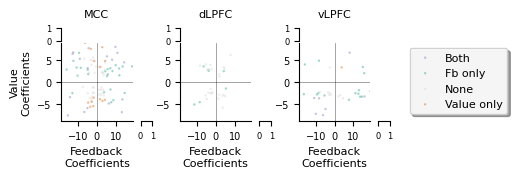

In [6]:
# plot coeffs
fig = plot_coeffs_vs_feedback_value(df_unit_significances, paper_format=True)